In [13]:
import xarray as xr
import numpy as np
from scipy.ndimage import label
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import pandas as pd
import pickle

In [2]:
def read_rgb_file(file_path):
    rgb_values = []
    with open(file_path, 'r') as file:
        for line in file:
            # Skip lines that are empty or start with '#' or contain non-integer values
            if line.strip() and not line.startswith('#') and all(c.isdigit() for c in line.split()):
                rgb_values.append([int(c) for c in line.split()])
    return np.array(rgb_values)
    
rgb_file_path = '/Users/lilydonaldson/Downloads/examples/util/colormap/precip_11lev.rgb'
# Read the RGB file and create a custom colormap
rgb_values = read_rgb_file(rgb_file_path)
rgb_values = rgb_values / 255.0  # Normalize the RGB values to [0, 1]
custom_cmap = ListedColormap(rgb_values)

In [3]:
# Function to find the closest closed SLP loop that contains the storm center, plot the SLP data with the loop highlighted, and print the area in km²
def find_and_plot_closest_closed_slp_loop(file_path, storm_center_lat, storm_center_lon, precip_correction_6th):
    # Load the dataset
    data = xr.open_dataset(file_path, engine='netcdf4')

    # Extract relevant data
    latitudes = data['latitude'].values
    longitudes = data['longitude'].values
    slp = data['MERRA2SLP'].values

    # Haversine formula to calculate distances
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371  # Earth radius in kilometers
        dlat = np.radians(lat2 - lat1)
        dlon = np.radians(lon2 - lon1)
        a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distance = R * c
        return distance

    # Find the closest grid point to the storm center
    distances = np.array([[haversine(storm_center_lat, storm_center_lon, lat, lon) for lon in longitudes[0]] for lat in latitudes[:, 0]])
    min_dist_idx = np.unravel_index(np.argmin(distances), distances.shape)
    closest_lat = latitudes[min_dist_idx]
    closest_lon = longitudes[min_dist_idx]

    # Finding the closed SLP loops (simplified approach)
    # Using the entire SLP field to identify minima and closed loops
    structure = np.ones((3, 3), dtype=bool)
    labeled, num_features = label(slp < np.percentile(slp, 50), structure=structure)  # Using 50th percentile to get reasonable number of loops

    # Calculate the centroid of each feature (closed loop)
    centroids = np.array([np.mean(np.column_stack(np.where(labeled == i)), axis=0) for i in range(1, num_features + 1)])

    # Convert centroids to lat/lon
    centroids_lat_lon = np.array([(latitudes[int(c[0]), 0], longitudes[0, int(c[1])]) for c in centroids])

    # Find all loops that contain the storm center
    containing_loops = []
    for i in range(1, num_features + 1):
        loop_mask = labeled == i
        loop_latitudes = latitudes[np.where(loop_mask)[0], 0]
        loop_longitudes = longitudes[0, np.where(loop_mask)[1]]
        if (storm_center_lat >= loop_latitudes.min()) and (storm_center_lat <= loop_latitudes.max()) and \
           (storm_center_lon >= loop_longitudes.min()) and (storm_center_lon <= loop_longitudes.max()):
            containing_loops.append(i)

    # Find the closest loop among those containing the storm center
    if not containing_loops:
        print("No closed loops contain the storm center.")
        return None, None, None, None, None, None

    closest_loop_idx = min(containing_loops, key=lambda i: haversine(storm_center_lat, storm_center_lon, centroids_lat_lon[i-1][0], centroids_lat_lon[i-1][1]))
    closest_centroid = centroids_lat_lon[closest_loop_idx-1]

    # Calculate the area of the closest closed SLP loop
    loop_mask = labeled == closest_loop_idx
    lat_diff = np.abs(np.diff(latitudes[:, 0])).mean() * (np.pi / 180) * 6371  # in km
    lon_diff = np.abs(np.diff(longitudes[0, :])).mean() * (np.pi / 180) * 6371  # in km
    loop_area = np.sum(loop_mask) * lat_diff * lon_diff

    # Create a mask for the SLP loop with the same shape and coordinates as precip_correction_6th
    mask = np.full(precip_correction_6th.shape, np.nan)
    for i in range(loop_mask.shape[0]):
        for j in range(loop_mask.shape[1]):
            lat_idx = np.abs(precip_correction_6th['lat'].values - latitudes[i, 0]).argmin()
            lon_idx = np.abs(precip_correction_6th['lon'].values - longitudes[0, j]).argmin()
            if loop_mask[i, j]:
                mask[lat_idx, lon_idx] = 1

    # Save the mask for later use
    mask_da = xr.DataArray(mask, coords=precip_correction_6th.coords, dims=precip_correction_6th.dims)

    # Plotting the SLP data and highlighting the closest closed loop
    plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-90, -50, 20, 60], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    
    contour = ax.contourf(longitudes, latitudes, slp, levels=20, cmap='tab20c', transform=ccrs.PlateCarree())
    plt.colorbar(contour, ax=ax, label='SLP (hPa)')
    
    # Highlight the closest closed loop in red
    ax.contour(longitudes, latitudes, labeled == closest_loop_idx, colors='red', linewidths=1.5, transform=ccrs.PlateCarree())

    ax.scatter(storm_center_lon, storm_center_lat, color='white', edgecolor='black', s=100, label='Storm Center', transform=ccrs.PlateCarree())
    ax.scatter(closest_centroid[1], closest_centroid[0], color='blue', edgecolor='black', s=100, label='Closed SLP Loop Center', transform=ccrs.PlateCarree())
    ax.set_title('MERRA2 Sea Level Pressure (SLP), \nFarthest Closed SLP Loop from Storm Center Outlined in Red\nDec 27 2010 06:00')
    ax.legend()
    plt.savefig("dec276_closedSLP.png")
    plt.show()

    print(f"Area of the closest closed SLP loop: {loop_area:.2f} km²")

    return mask_da, closest_lat, closest_lon, longitudes, latitudes, loop_mask

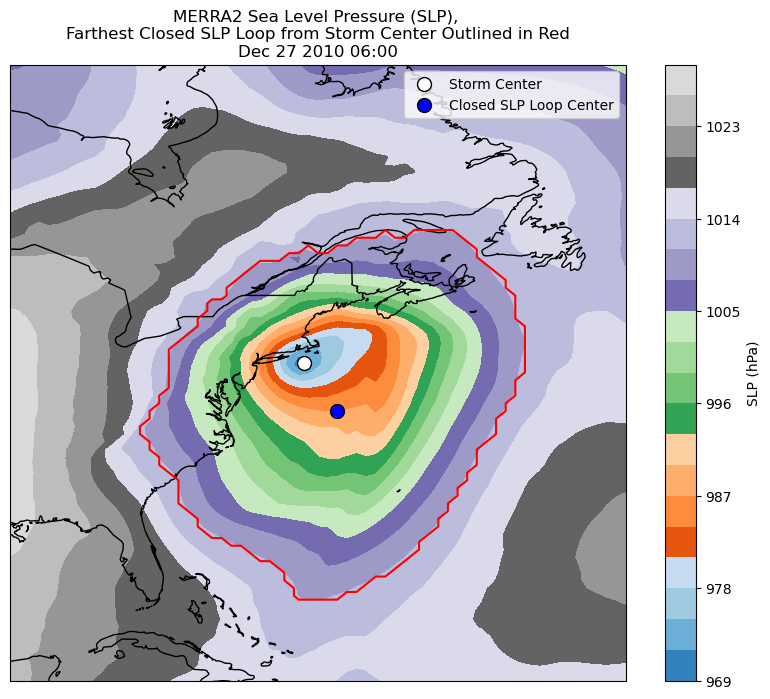

Area of the closest closed SLP loop: 5077095.50 km²


In [6]:
# Using the function
file_path = "/Volumes/SSK Drive /merra2fronts/merra2fronts2010/201012/MERRA2fronts_20101227_06_40.61_-70.89_ocean_20101225060615026700.ncdf"
storm_center_lat = 40.61
storm_center_lon = -70.89

# Load the precipitation data
prec_file_path = "/Users/lilydonaldson/Downloads/examples/data/MERRA-2/07-24/2010/MERRA2_300.tavg1_2d_flx_Nx.20101227.SUB.nc"
merra2 = xr.open_dataset(prec_file_path)
precip_correction_6th = merra2['PRECTOTCORR'].isel(time=5)* 3600

mask, closest_lat, closest_lon, slp_lons, slp_lats, loop_mask = find_and_plot_closest_closed_slp_loop(file_path, storm_center_lat, storm_center_lon, precip_correction_6th)

# Apply the mask to precip_correction_6th
masked_precip_correction_6th = precip_correction_6th * mask

In [7]:
# Plot the masked precip_correction_6th with the same x and y ranges as the SLP plot
def plot_masked_precip(timestep, masked_precip, slp_lons, slp_lats, loop_mask):
    plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-90, -50, 20, 60], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    
    # Plot masked precipitation
    masked_precip.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=custom_cmap, cbar_kwargs={'label': 'Precipitation (mm/hour)'})
    
    # Outline the storm boundary in red
    ax.contour(slp_lons, slp_lats, loop_mask, colors='red', linewidths=1.5, transform=ccrs.PlateCarree())
    
    ax.gridlines(draw_labels=True)
    ax.set_title(f'Masked Precipitation for {timestep}')
    plt.show()

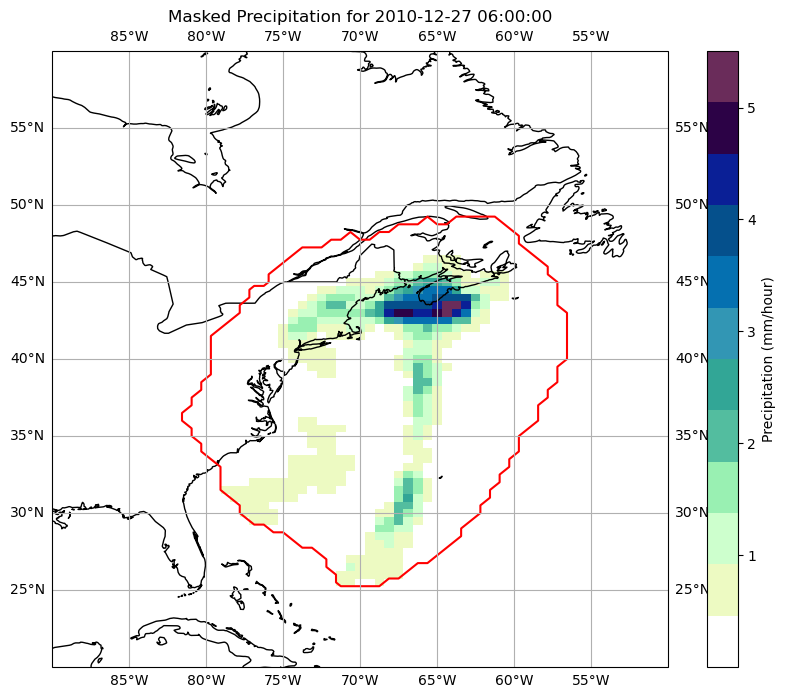

In [10]:
timestep_to_plot = pd.Timestamp('2010-12-27 06:00:00')
plot_masked_precip(timestep_to_plot, masked_precip_correction_6th, slp_lons, slp_lats, loop_mask)